# ****Check GPU****

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is being used!")
    except RuntimeError as e:
        print(e)

2025-04-22 23:51:50.463012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745365910.776458      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745365910.848675      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is being used!


# **Import Dataset**

In [2]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image

In [3]:
import kagglehub
import os

# Download the dataset from KaggleHub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# Match GitHub structure by creating a new parent dir name
dataset_directory_location = os.path.join(path)
os.listdir(dataset_directory_location)

# GitHub-style train/test folder names (manually renamed or aliased from 'Training' and 'Testing')
train_dataset_location = os.path.join(dataset_directory_location, 'Training')  # or 'train' if renamed
test_dataset_location = os.path.join(dataset_directory_location, 'Testing')    # or 'test' if renamed

# Check the contents to confirm
if os.path.exists(train_dataset_location) and os.path.exists(test_dataset_location):
    print("✅ Train and Test Paths Exist")
    print("🧠 Train Classes:", os.listdir(train_dataset_location))
    print("🧠 Test Classes:", os.listdir(test_dataset_location))
else:
    raise FileNotFoundError("❌ Error: Train or Test path does not exist.")

✅ Train and Test Paths Exist
🧠 Train Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
🧠 Test Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [4]:
print("Base path:", path)
print("Contents:", os.listdir(path))

Base path: /kaggle/input/brain-tumor-mri-dataset
Contents: ['Training', 'Testing']


# **Dataset Loading and Preprocessing**

In [5]:
correct_image_shape = (224, 224, 3)

train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    train_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

test_image_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Sample Visualisation**

(512, 512, 3)

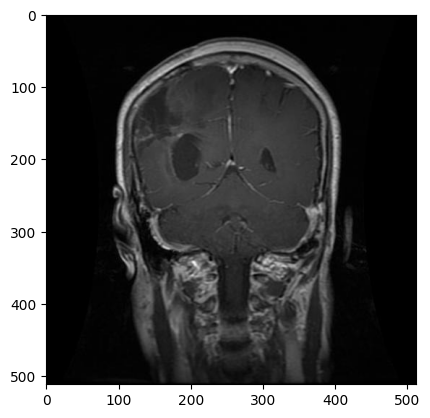

In [6]:
brain_img_glicoma = os.path.join(train_dataset_location, 'glioma')
os.listdir(brain_img_glicoma)[:1]
brain_img_glicoma_read = imread(os.path.join(brain_img_glicoma, 'Tr-gl_0010.jpg'))
plt.imshow(brain_img_glicoma_read)
brain_img_glicoma_read.shape 

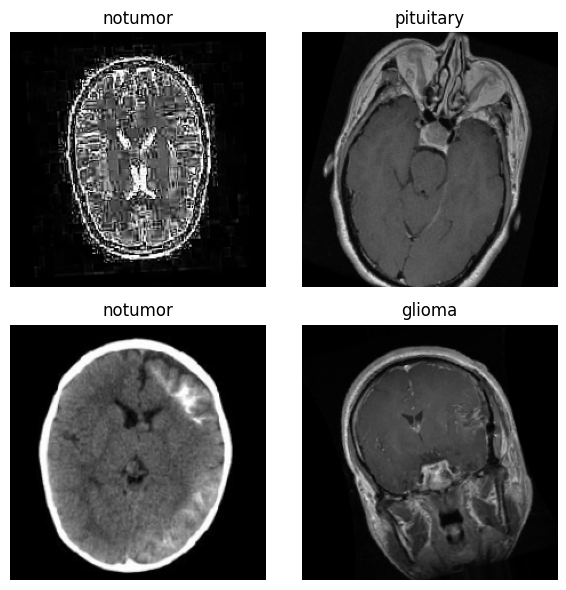

In [7]:
import matplotlib.pyplot as plt

# Helper function to show images from the generator
def show_images(generator, class_names, num_images=4):
    images, labels = next(generator)  # fetch one batch
    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i].argmax()])  # decode one-hot
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Extract class names from the generator itself
class_names = list(train_image_gen.class_indices.keys())

# Call the function with your training generator
show_images(train_image_gen, class_names)

# **Build and Train Model**

In [8]:
model = Sequential()
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=correct_image_shape)
vgg19_model.trainable = False
model.add(vgg19_model)

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))
model.summary()

I0000 00:00:1745365954.611959      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745365954.612643      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25088)               │         100,352 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,341,028 (89.04 MB)

 Trainable params: 3,266,148 (12.46 MB)

 Non-trainable params: 20,074,880 (76.58 MB)

In [10]:
from IPython.display import FileLink, display
from tensorflow.keras.callbacks import ModelCheckpoint
import json

# Constants
MODEL_PATH = "/kaggle/working/vgg19_model.keras"
HISTORY_PATH = "/kaggle/working/vgg19_history.json"

# Early stopping callbacks
early_stop_loss = EarlyStopping(monitor='loss', patience=2, verbose=1)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

checkpoint_cb = ModelCheckpoint(
    MODEL_PATH,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Callbacks
early_stop_loss = EarlyStopping(monitor='loss', patience=2, verbose=1)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
checkpoint_cb = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Compile model
model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_image_gen,
    validation_data=test_image_gen,
    epochs=30,
    callbacks=[early_stop_loss, early_stop_val_loss, checkpoint_cb]
)

# Save training history
with open(HISTORY_PATH, "w") as f:
    json.dump(history.history, f)

# Show download links
print("✅ VGG19 model and training history saved!")
display(FileLink(MODEL_PATH, result_html_prefix="📥 Download VGG19 model: "))
display(FileLink(HISTORY_PATH, result_html_prefix="📊 Download training history: "))

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745366054.155351     115 service.cc:148] XLA service 0x7da4a801afc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745366054.156651     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745366054.156687     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745366054.745493     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/357 ━━━━━━━━━━━━━━━━━━━━ 1:34:46 16s/step - accuracy: 0.2500 - loss: 2.4913

I0000 00:00:1745366063.690847     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.4533 - loss: 1.5127
Epoch 1: val_accuracy improved from -inf to 0.72693, saving model to /kaggle/working/vgg19_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 127s 313ms/step - accuracy: 0.4536 - loss: 1.5119 - val_accuracy: 0.7269 - val_loss: 0.7673
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6955 - loss: 0.8382
Epoch 2: val_accuracy improved from 0.72693 to 0.79863, saving model to /kaggle/working/vgg19_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 81s 222ms/step - accuracy: 0.6956 - loss: 0.8381 - val_accuracy: 0.7986 - val_loss: 0.5647
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7436 - loss: 0.7209
Epoch 3: val_accuracy improved from 0.79863 to 0.82304, saving model to /kaggle/working/vgg19_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 80s 221ms/step - accuracy: 0.7436 - loss: 0.7208 - val_accuracy: 0.8230 - val_loss: 0.4968
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.779

/kaggle/working/vgg19_model.keras

/kaggle/working/vgg19_history.json

# **Graphical Loss vs Accuracy plot**

In [11]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv("/kaggle/working/training_history.csv", index=False)

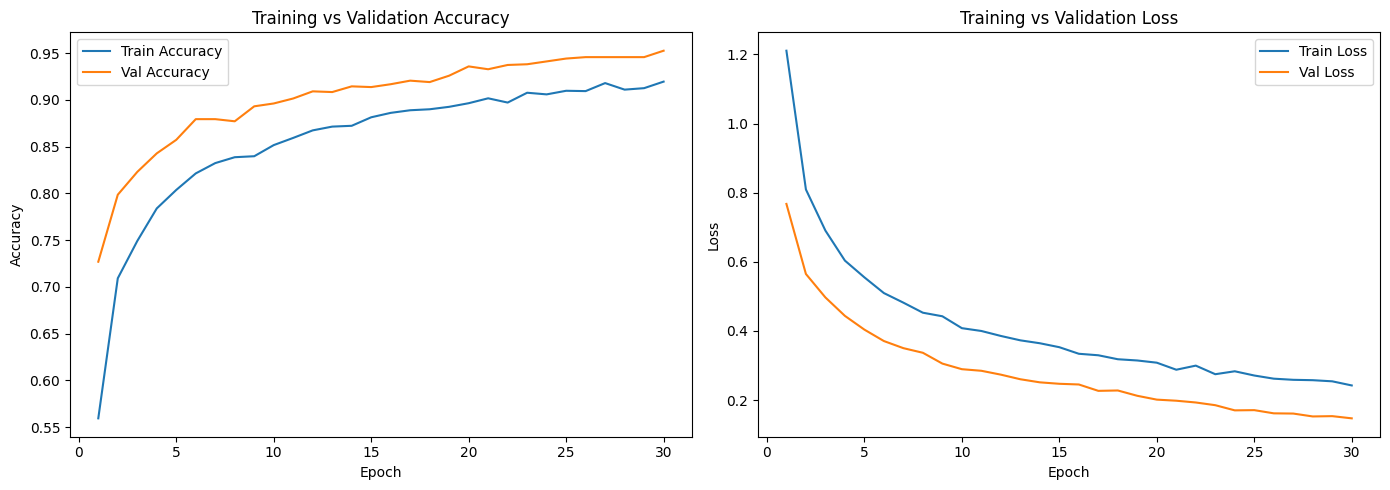

In [12]:
import matplotlib.pyplot as plt

# Load history from the DataFrame (already created)
acc = history_df["accuracy"]
val_acc = history_df["val_accuracy"]
loss = history_df["loss"]
val_loss = history_df["val_loss"]

epochs = range(1, len(acc) + 1)

# Create a figure with two subplots
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# **Model Evaluation**

In [13]:
# Evaluate on training data
train_acc = model.evaluate(train_image_gen, steps=len(train_image_gen))[1]

# Evaluate on test data
test_acc = model.evaluate(test_image_gen, steps=len(test_image_gen))[1]

print(f"✅ Final Train Accuracy: {train_acc:.4f}")
print(f"✅ Final Test Accuracy: {test_acc:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - accuracy: 0.9761 - loss: 0.0816
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9607 - loss: 0.1307
✅ Final Train Accuracy: 0.9767
✅ Final Test Accuracy: 0.9527


# **Sample Prediction**

In [14]:
# Choose an image path to test
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0012.jpg"

# Load and preprocess the image
sample_img_load = image.load_img(img_path, target_size=correct_image_shape)
sample_img_to_arr = image.img_to_array(sample_img_load)
sample_img_to_arr = sample_img_to_arr / 255.0  # Normalize
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, axis=0)

# Predict
prediction = model.predict(sample_img_to_arr_expand_dim)[0]
pred_result = np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [15]:
# Define class names in order of training
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
pred_final_result = class_names[pred_result]

# Output
print(f"🧠 Predicted Tumor Type: {pred_final_result}")

🧠 Predicted Tumor Type: glioma
